In [1]:
import torch

In [2]:
print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 4070 Laptop GPU
Using device: cuda


In [1]:
import numpy as np
import rustworkx as rx
from sklearn.cluster import KMeans, AgglomerativeClustering, MiniBatchKMeans
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import normalize
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.transforms import functional as F
from scipy.sparse import csr_matrix, lil_matrix, diags
from transformers import AutoImageProcessor, SuperPointForKeypointDetection
import pickle

# Vocab Tree

In [ ]:
class VocabularyTree:
    def __init__(self, num_branches: int, depth: int, image_descriptor_function, clustering_algorithm=None, **kwargs):
        """
        Initializes the Vocabulary Tree.

        Args:
            num_branches: Number of branches at each node.
            depth: Depth of the tree.
            image_descriptor: Function to extract features from images.
            clustering_algorithm: Clustering algorithm to use.
            clustering_params: Parameters for the clustering algorithm.
        """
        self.num_branches = num_branches
        self.depth = depth
        self.image_descriptor = image_descriptor_function
        self.tree = rx.PyDiGraph()  # Directed graph for the vocabulary tree

        if clustering_algorithm is None:
            self.clustering_algorithm = KMeans
        else:
            self.clustering_algorithm = clustering_algorithm
        self.clustering_params = kwargs

        self.image_idx_image_mapping = {}
        self.weights = None
        self.bof = None

    def extract_image_features(self, imagepaths):
        """
        Extracts features for a given array of images.

        Args:
            imagepaths: Array of image paths
        Returns:
            Array of feature descriptors for the images.
        """

        image_descriptors = []
        for imagepath in imagepaths:
            image = cv2.imread(imagepath)
            image_descriptors.append(self.image_descriptor(image))
        return image_descriptors
    

    def create_tree(self, feature_descriptions, current_node=0, node_value=None, current_depth=0):
        """
        Recursively builds the vocabulary tree.

        Args:
            feature_descriptions: Array of feature descriptions.
            current_node: Current node in the tree.
            node_value: Value of the current node (e.g., cluster centroid).
            current_depth: Current depth in the tree.
        """

        if current_node == 0: # If the current node is the root, add root to tree.
            self.tree.add_node(None)
            node_value = np.mean(feature_descriptions, axis=0)

        self.tree[current_node] = {'node_value': node_value, 'inverted_index': {}}


        # Stop if the max depth is reached or no more features to process
        if current_depth >= self.depth or len(feature_descriptions) < self.num_branches:
            return

        unique_descriptors = np.unique(feature_descriptions, axis=0) # Avoid creating clusters with no elements
        if len(unique_descriptors) < self.num_branches:
            return
        
        clustering = self.clustering_algorithm(n_clusters=self.num_branches, random_state=42, **self.clustering_params)
        clustering.fit(feature_descriptions)

        for branch_id in range(self.num_branches):
            child_node = self.tree.add_node(None)
            self.tree.add_edge(current_node, child_node, branch_id)

            cluster_features = feature_descriptions[clustering.labels_ == branch_id]
            cluster_centroid = clustering.cluster_centers_[branch_id]

            self.create_tree(cluster_features, child_node, cluster_centroid, current_depth + 1)


    def build_inverted_index(self, feature_dict):
        """
        Builds the inverted index for the vocabulary tree.

        Args:
            feature_dict: Dictionary mapping image IDs to feature descriptors.
        """

        for image_id, feature_descriptor in feature_dict.items():
            for feature in feature_descriptor:
                current_node = 0

                while self.tree.out_degree(current_node) > 0:
                    children = list(self.tree.successor_indices(current_node))
                    distances = [np.linalg.norm(feature - self.tree[node]['node_value']) for node in children]
                    closest_child = children[np.argmin(distances)]

                    current_node = closest_child

                if image_id in self.tree[current_node]["inverted_index"]:
                    self.tree[current_node]["inverted_index"][image_id] += 1
                else:
                    self.tree[current_node]["inverted_index"][image_id] = 1

    def get_inverted_index(self, node):
        """
        Recursively traverses the tree and returns the inverted index of the child node.

        Args:
            node: Current node in the tree.

        Returns:
            Inverted index of the child node.
        """
        if self.tree.out_degree(node) == 0:

            return self.tree[node]["inverted_index"]
        else:
            inverted_idx = {}
            children = list(self.tree.successor_indices(node))
            for child in children:
                child_inverted_idx = self.get_inverted_index(child)
                for image_id, count in child_inverted_idx.items():
                    if image_id in inverted_idx:
                        inverted_idx[image_id] += count
                    else:
                        inverted_idx[image_id] = count
            return inverted_idx


    def compute_bof(self, num_images):
        """
        Computes the sparse 2D bag of features vector for the vocabulary tree.
        Args:
            num_images: Number of images in the training dataset
        """
        num_nodes = len(self.tree)
        self.weights = np.zeros(num_nodes)

        self.bof = lil_matrix((num_images, num_nodes))
        
        for node in self.tree.node_indexes():
            inverted_idx = self.get_inverted_index(node)
            self.weights[node] = np.log(num_images / len(inverted_idx))

            for image_id, count in inverted_idx.items():
                self.bof[(image_id, node)] = self.weights[node] * count
        

        self.bof = csr_matrix(self.bof)

        row_sums = self.bof.sum(axis=1)
        row_sums_reciprocal = 1.0 / row_sums
        diagonal_matrix = diags(row_sums_reciprocal.A1)
        normalized_matrix = diagonal_matrix.dot(self.bof)
        self.bof = normalized_matrix

    def fit(self, images):
        """
        Fits the vocabulary tree to the training dataset.

        Args:
            images: Array of image paths.
        """

        image_features = self.extract_image_features(images)

        cnt = 0
        non_null_features = []
        image_features_flattened = []
        idx_mapping = {}

        for i in range(len(image_features)):
            if image_features[i] is not None:
                non_null_features.append(image_features[i])
                idx_mapping[cnt] = images[i]
                cnt += 1
                image_features_flattened.extend(image_features[i])
        image_features = np.array(image_features_flattened)

        image_ids = np.arange(len(non_null_features))
        self.image_idx_image_mapping = idx_mapping

        feature_dict = {image_id: features for image_id, features in zip(image_ids, non_null_features)}

        self.create_tree(image_features)
        self.build_inverted_index(feature_dict)
        self.compute_bof(len(non_null_features))


    def get_query_bof(self, feature_descriptors):
        """
        Computes the bag of features for the query image.
        Args:
            feature_descriptors: Array of feature descriptors for the query image.
        Returns:
            Bag of features for the query image.
        """
        bof = np.zeros(len(self.tree))

        for feature in feature_descriptors:
            current_node = 0
            
            bof[current_node] += 1*self.weights[current_node]

            while self.tree.out_degree(current_node) > 0:
                children = list(self.tree.successor_indices(current_node))
                distances = [np.linalg.norm(feature - self.tree[node]['node_value']) for node in children]
                closest_child = children[np.argmin(distances)]

                current_node = closest_child

                bof[current_node] += 1*self.weights[current_node]
        
        return bof

    def query(self, image):
        """
        Queries the vocabulary tree for similar images.
        Args:
            image: Query image.
        Returns:
            Similar image paths and their scores.
        """
        image_features = self.image_descriptor(image)

        qbof = self.get_query_bof(image_features)
        qbof /= np.sum(qbof)

        non_zero_q_nodes = np.nonzero(qbof)[0]

        scores = {}

        for image_id in range(self.bof.shape[0]):
            bof = self.bof.getrow(image_id).toarray()[0]
            
            score = 2
            
            non_zero_bof_nodes = np.nonzero(bof)[0]
            intersection = np.intersect1d(non_zero_q_nodes, non_zero_bof_nodes)

            for i in intersection:
                score += np.abs(qbof[i] - bof[i]) - np.abs(qbof[i]) - np.abs(bof[i])

            scores[image_id] = score

        scores = {k: v for k, v in sorted(scores.items(), key=lambda item: item[1])}
        images = {k: self.image_idx_image_mapping[k] for k in scores.keys()}
        return scores, images


# Descriptors

In [ ]:
def baseline(image):
    orb = cv2.ORB_create()
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, feature_descrip = orb.detectAndCompute(gray_image, None)

    return feature_descrip

def opponent_sift(image):

    R, G, B = image[:, :, 2], image[:, :, 1], image[:, :, 0]
    O1 = (R - G) / np.sqrt(2)
    O2 = (R + G - 2 * B) / np.sqrt(6)
    O3 = (R + G + B) / np.sqrt(3)
    opponent_image = np.stack([O1, O2, O3], axis=-1)

    sift = cv2.SIFT_create()
    descriptors = []
    for i in range(3):
        _, desc = sift.detectAndCompute(opponent_image[:, :, i].astype(np.uint8), None)
        if desc is not None:
            descriptors.append(desc)

    return np.vstack(descriptors) if descriptors else None


def compute_orb_features(image):
    """
    Compute ORB features for each channel of a color image and combine them.
    
    Parameters:
        image (numpy.ndarray): Input color image in BGR format.
    
    Returns:
        tuple: ORB descriptors for each channel.
    """

    blue_channel, green_channel, red_channel = cv2.split(image)

    orb = cv2.ORB_create()

    _, des_blue = orb.detectAndCompute(blue_channel, None)
    _, des_green = orb.detectAndCompute(green_channel, None)
    _, des_red = orb.detectAndCompute(red_channel, None)
    

    descriptors = []
    for des in [des_blue, des_green, des_red]:
        if des is not None:
            descriptors.append(des)
    combined_descriptors = np.vstack(descriptors) if descriptors else None
    
    return combined_descriptors

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

resnet_model = models.resnet50(pretrained=True).to(device).eval()

resnet_feature_extractor = torch.nn.Sequential(*list(resnet_model.children())[:-2])
resnet_feature_extractor = resnet_feature_extractor.to(device)

resnet_feature_map = None


def _hook_fn(module, input, output):
    global resnet_feature_map
    resnet_feature_map = output


resnet_model.layer4.register_forward_hook(_hook_fn)

def generate_orb_resnet_features(image):
    """
    Detects keypoints using ORB and generates feature descriptors using ResNet.

    Args:
        image: Input image (numpy array, HxWx3).

    Returns:
        descriptors: Array of feature descriptors for the detected keypoints.
    """

    orb = cv2.ORB_create()
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    keypoints = orb.detect(gray_image, None)

    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(image).unsqueeze(0).to(device)
    _ = resnet_model(input_tensor)
    feature_map_np = resnet_feature_map.squeeze(0).detach().cpu().numpy()

    height, width = feature_map_np.shape[1], feature_map_np.shape[2]
    scale_x = width / 224
    scale_y = height / 224

    descriptors = []
    for kp in keypoints:
        x, y = int(kp.pt[0] * scale_x), int(kp.pt[1] * scale_y)
        x = min(max(x, 0), width - 1)
        y = min(max(y, 0), height - 1)
        descriptors.append(feature_map_np[:, y, x])

    return np.array(descriptors)


superpoint_processor = AutoImageProcessor.from_pretrained("magic-leap-community/superpoint")
superpoint_model = SuperPointForKeypointDetection.from_pretrained("magic-leap-community/superpoint")
superpoint_model = superpoint_model.to(device)

def superpoint_features(image):

    superpoint_inputs = superpoint_processor(image, return_tensors="pt")

    superpoint_inputs = {k: v.to(device) for k, v in superpoint_inputs.items()}

    superpoint_outputs = superpoint_model(**superpoint_inputs)

    descriptors = superpoint_outputs['descriptors'][0].detach().cpu().numpy()
    return descriptors



# Preprocessing

In [6]:
big_data_styles = pd.read_csv(os.getcwd() + "\\big_dataset\\dataset\\fashion-dataset\\styles.csv", on_bad_lines='skip')

In [7]:
big_data_styles.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [8]:
big_data_styles.dropna(inplace=True)

In [9]:
color_mapping = {
    'Navy Blue': 'Blue',
    'Blue': 'Blue',
    'Silver': 'Silver',
    'Black': 'Black',
    'Grey': 'Grey',
    'Green': 'Green',
    'Purple': 'Purple',
    'White': 'White',
    'Beige': 'Beige',
    'Brown': 'Brown',
    'Bronze': 'Brown',
    'Teal': 'Green',
    'Copper': 'Brown',
    'Pink': 'Pink',
    'Off White': 'White',
    'Maroon': 'Red',
    'Red': 'Red',
    'Khaki': 'Brown',
    'Orange': 'Orange',
    'Coffee Brown': 'Brown',
    'Yellow': 'Yellow',
    'Charcoal': 'Grey',
    'Gold': 'Yellow',
    'Steel': 'Silver',
    'Tan': 'Brown',
    'Multi': 'Multi',
    'Magenta': 'Pink',
    'Lavender': 'Purple',
    'Sea Green': 'Green',
    'Cream': 'White',
    'Peach': 'Orange',
    'Olive': 'Green',
    'Skin': 'Beige',
    'Burgundy': 'Red',
    'Grey Melange': 'Grey',
    'Rust': 'Red',
    'Rose': 'Pink',
    'Lime Green': 'Green',
    'Mauve': 'Pink',
    'Turquoise Blue': 'Blue',
    'Metallic': 'Silver',
    'Mustard': 'Yellow',
    'Taupe': 'Beige',
    'Nude': 'Beige',
    'Mushroom Brown': 'Brown',
    'Fluorescent Green': 'Green',
    'nan': 'NA'
}


big_data_styles['baseColour'] = big_data_styles['baseColour'].replace(color_mapping)
big_data_styles = big_data_styles[big_data_styles['baseColour'] != 'NA']


In [ ]:

article_types = [
    'Tshirts', 'Jeans', 'Sweaters', 'Shirts', 'Dresses', 'Shorts',
    'Casual Shoes', 'Skirts'
]


filtered_data = []
for article_type in article_types:
    filtered_article_type = big_data_styles[big_data_styles['articleType'] == article_type]
    sampled_data = filtered_article_type.sample(n=125, random_state=42)
    filtered_data.append(sampled_data)


training_df = pd.concat(filtered_data)

training_df.reset_index(drop=True, inplace=True)

test_data = []

for article_type in article_types:
    article_df = big_data_styles[big_data_styles['articleType'] == article_type]
    
    non_training_data = article_df[~article_df['id'].isin(training_df['id'])]
    
    sampled_test_data = non_training_data.sample(n= min(len(non_training_data), 20), random_state=42)
    test_data.append(sampled_test_data)

test_df = pd.concat(test_data)

test_df.reset_index(drop=True, inplace=True)


In [11]:
training_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,26363,Women,Apparel,Topwear,Tshirts,White,Summer,2012.0,Casual,Arrow Woman Printed White T-shirt
1,13967,Men,Apparel,Topwear,Tshirts,Red,Fall,2011.0,Casual,Ed Hardy Men Printed Red Tshirts
2,10373,Men,Apparel,Topwear,Tshirts,Black,Fall,2011.0,Casual,United Colors of Benetton Men Solid Black Tshirts
3,50194,Boys,Apparel,Topwear,Tshirts,Black,Summer,2012.0,Casual,Gini and Jony Boys Black T-shirt
4,58372,Men,Apparel,Topwear,Tshirts,Beige,Summer,2012.0,Casual,Locomotive Men Beige T-shirt


In [12]:
training_df['image_path'] = training_df['id'].apply(lambda x: os.getcwd() + "\\big_dataset\\dataset\\fashion-dataset\\images\\" + str(x) + ".jpg")
test_df['image_path'] = test_df['id'].apply(lambda x: os.getcwd() + "\\big_dataset\\dataset\\fashion-dataset\\images\\" + str(x) + ".jpg")

In [53]:
training_df['color_articleType'] = training_df['baseColour'] + "_" + training_df['articleType']
test_df['color_articleType'] = test_df['baseColour'] + "_" + test_df['articleType']

In [13]:
len(training_df), len(test_df)

(1000, 143)

In [23]:
training_df['articleType'].value_counts()

articleType
Tshirts         125
Jeans           125
Sweaters        125
Shirts          125
Dresses         125
Shorts          125
Casual Shoes    125
Skirts          125
Name: count, dtype: int64

In [24]:
test_df['articleType'].value_counts()

articleType
Tshirts         20
Jeans           20
Sweaters        20
Shirts          20
Dresses         20
Shorts          20
Casual Shoes    20
Skirts           3
Name: count, dtype: int64

In [25]:
training_df['baseColour'].value_counts()

baseColour
Blue      304
Black     192
White     106
Grey       83
Red        66
Purple     55
Green      55
Brown      51
Pink       50
Beige      14
Yellow     12
Orange      7
Multi       5
Name: count, dtype: int64

In [26]:
test_df['baseColour'].value_counts()

baseColour
Blue      45
Black     30
White     20
Pink      12
Green      9
Grey       8
Red        6
Brown      5
Beige      3
Purple     2
Yellow     2
Orange     1
Name: count, dtype: int64

In [99]:
training_df.to_csv('training_df.csv', index=False)
test_df.to_csv('test_df.csv', index=False)

In [ ]:
def read_and_plot_img(img_path):
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(img_rgb)
    plt.show()


def plot_top_k_images(scores, images, k):
    """
    Plots the top k images with their scores as titles.

    Args:
        scores: A dictionary with image IDs as keys and scores as values.
        images: A dictionary with image IDs as keys and images (numpy arrays) as values.
        k: The number of top images to plot.
    """

    top_k_ids = sorted(scores, key=scores.get, reverse=False)[:k]
    top_k_scores = [scores[image_id] for image_id in top_k_ids]
    top_k_images = [images[image_id] for image_id in top_k_ids]


    n_cols = min(3, k)
    n_rows = (k + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))

    axes = axes.ravel() if k > 1 else [axes]

    for i in range(k):
        img = top_k_images[i]
        if isinstance(img, str):
            img = cv2.imread(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img)
        axes[i].set_title(f"Score: {top_k_scores[i]:.2f}", fontsize=10)
        axes[i].axis("off")

    for j in range(k, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


In [14]:
query_test_img = cv2.imread(test_df.iloc[7]['image_path'])

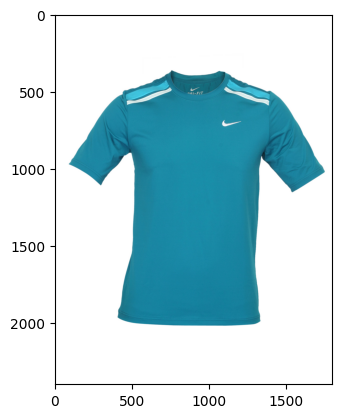

In [17]:
read_and_plot_img(test_df.iloc[7]['image_path'])

# Experimentation

### Baseline

In [46]:
tree_orb_baseline_16_5 = VocabularyTree(num_branches=16, depth=5, image_descriptor_function=baseline)
tree_orb_baseline_16_5.fit(training_df['image_path'])

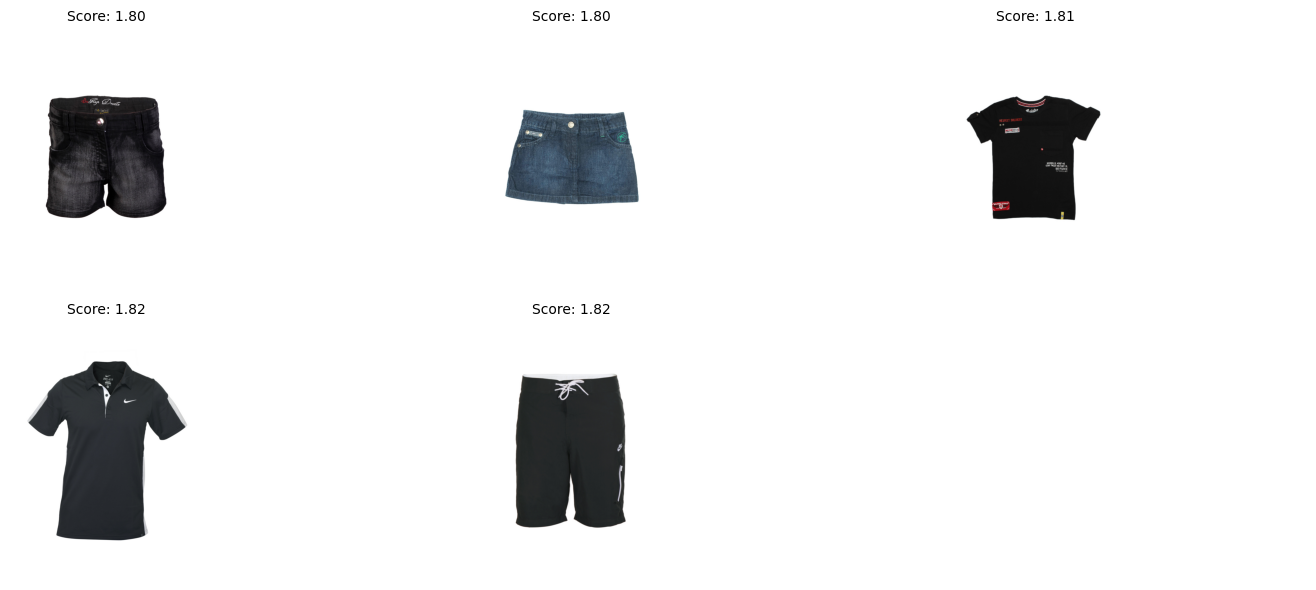

In [47]:
tree_orb_baseline_16_5_scores, tree_orb_baseline_16_5_images = tree_orb_baseline_16_5.query(query_test_img)
plot_top_k_images(tree_orb_baseline_16_5_scores, tree_orb_baseline_16_5_images, 5)

In [48]:
with open('trees\\tree_orb_baseline_16_5.pkl', 'wb') as f:
    pickle.dump(tree_orb_baseline_16_5, f)
f.close()

### Opponent SIFT

#### B:32, H:6

In [18]:
tree_opp_sift_32_6 = VocabularyTree(num_branches=32, depth=6, image_descriptor_function=opponent_sift)
tree_opp_sift_32_6.fit(training_df['image_path'])

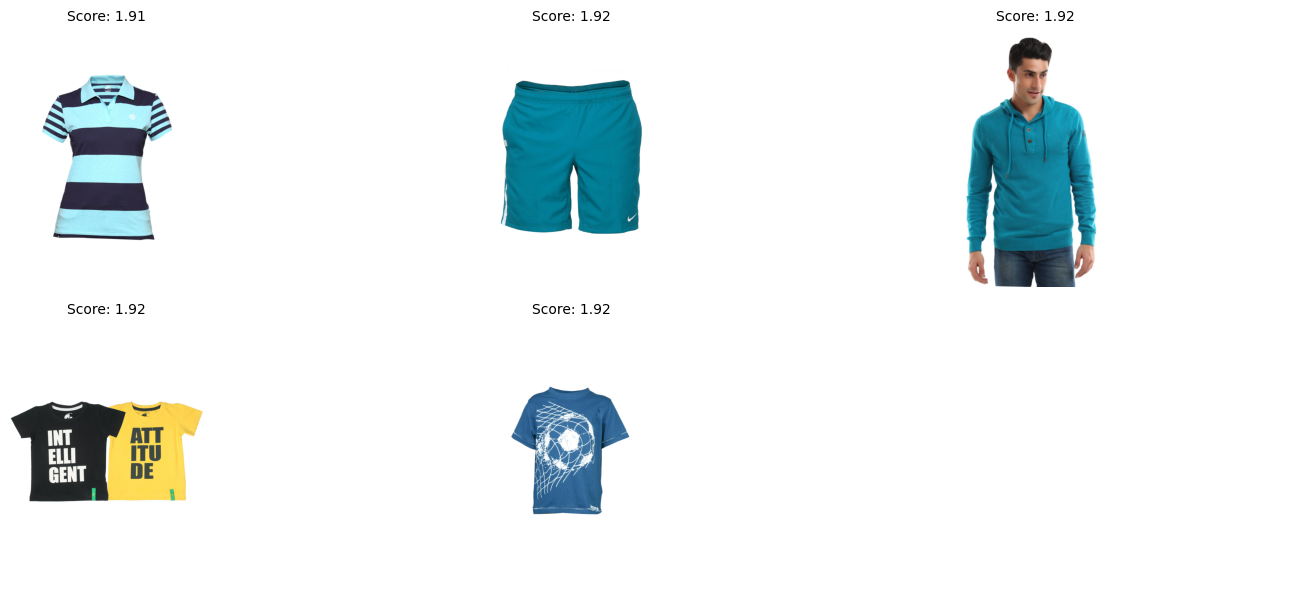

In [19]:
tree_opp_sift_32_6_scores, tree_opp_sift_32_6_images = tree_opp_sift_32_6.query(query_test_img)
plot_top_k_images(tree_opp_sift_32_6_scores, tree_opp_sift_32_6_images, 5)

In [21]:
import pickle

In [22]:
with open('trees\\tree_opp_sift_32_6.pkl', 'wb') as f:
    pickle.dump(tree_opp_sift_32_6, f)
f.close()

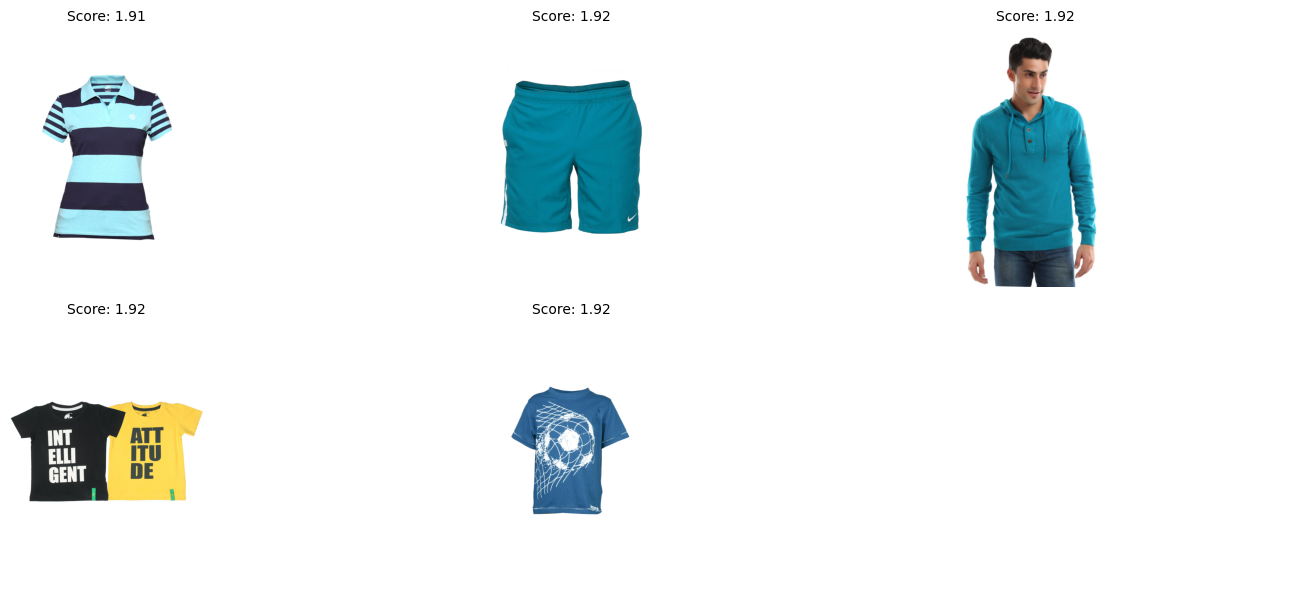

In [ ]:
with open('trees\\tree_opp_sift_32_6.pkl', 'rb') as f:
    tmp_opp_sift_32_6 = pickle.load(f)
f.close()

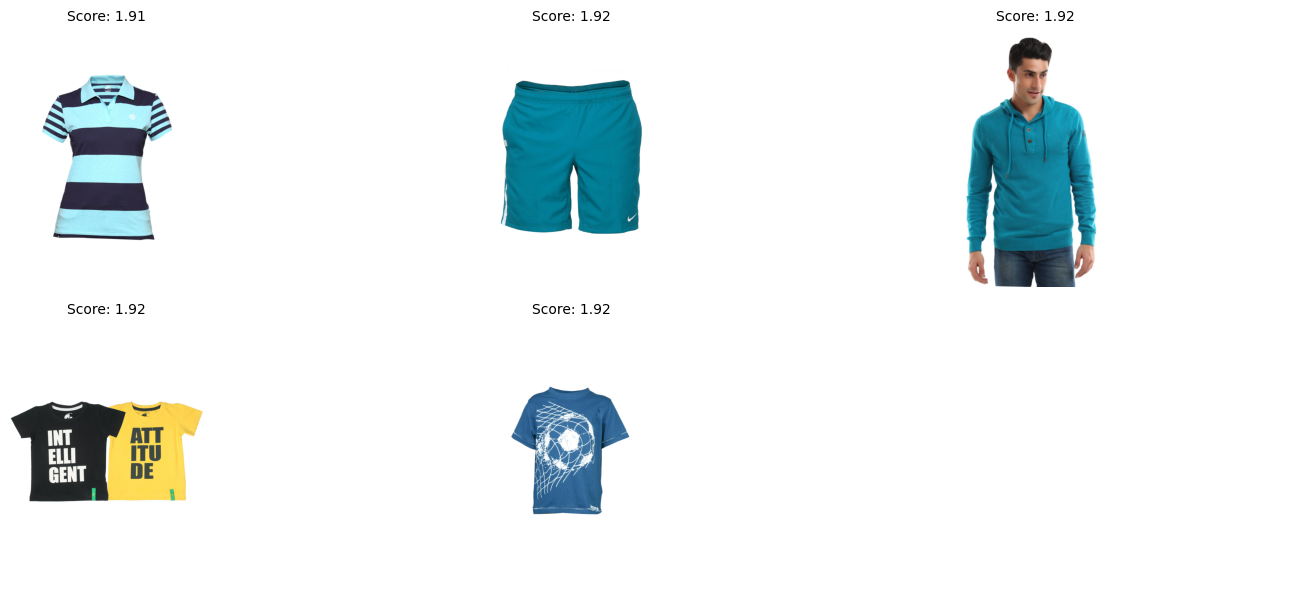

In [28]:
tmp_opp_sift_32_6_scores, tmp_opp_sift_32_6_images = tmp_opp_sift_32_6.query(query_test_img)
plot_top_k_images(tmp_opp_sift_32_6_scores, tmp_opp_sift_32_6_images, 5)

In [ ]:
del(tmp_opp_sift_32_6)

### ORB - Multi Channel

#### B:16, H:5

In [30]:
tree_orb_16_5 = VocabularyTree(num_branches=16, depth=5, image_descriptor_function=compute_orb_features)
tree_orb_16_5.fit(training_df['image_path'])

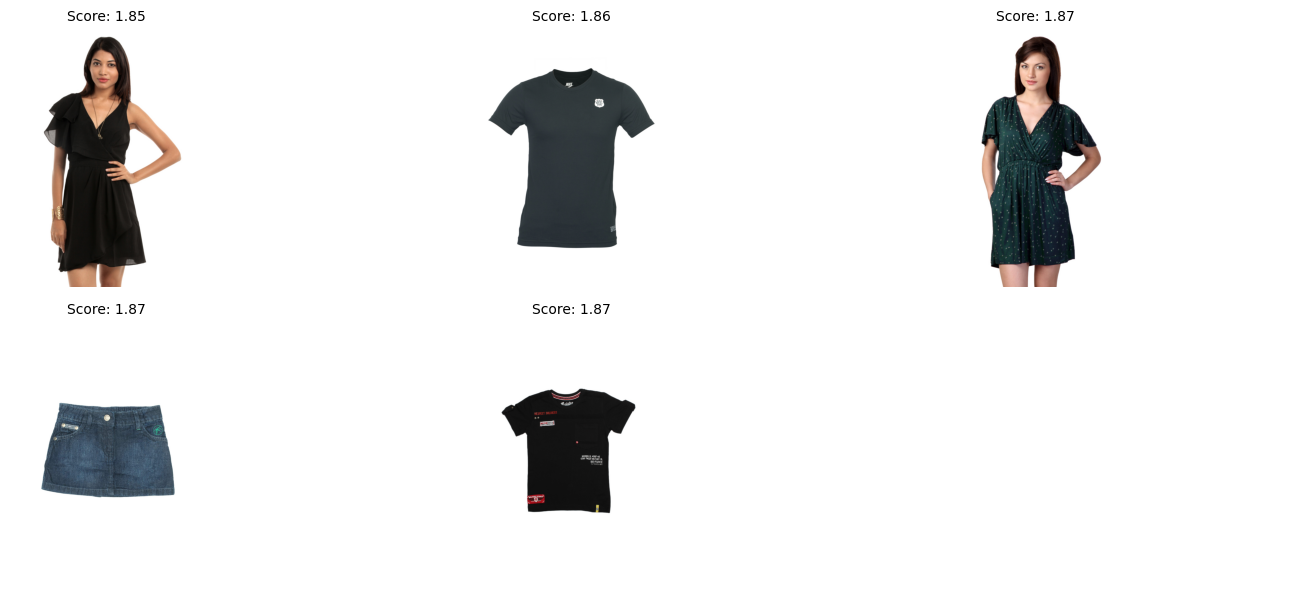

In [31]:
tree_orb_16_5_scores, tree_orb_16_5_images = tree_orb_16_5.query(query_test_img)
plot_top_k_images(tree_orb_16_5_scores, tree_orb_16_5_images, 5)

In [32]:
with open('trees\\tree_orb_16_5.pkl', 'wb') as f:
    pickle.dump(tree_orb_16_5, f)
f.close()

#### B:32, H:6

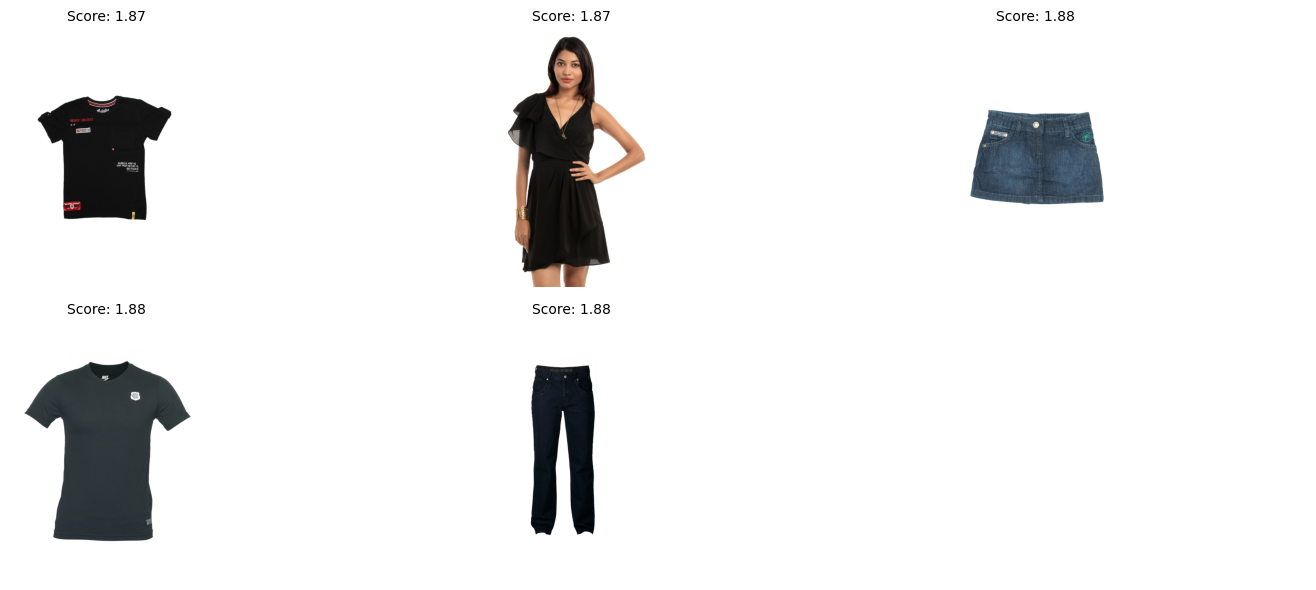

In [33]:
tree_orb_32_6 = VocabularyTree(num_branches=32, depth=6, image_descriptor_function=compute_orb_features)
tree_orb_32_6.fit(training_df['image_path'])

tree_orb_32_6_scores, tree_orb_32_6_images = tree_orb_32_6.query(query_test_img)
plot_top_k_images(tree_orb_32_6_scores, tree_orb_32_6_images, 5)

with open('trees\\tree_orb_32_6.pkl', 'wb') as f:
    pickle.dump(tree_orb_32_6, f)
f.close()

### ORB + Resnet

#### B:16, H:5

In [39]:
tree_orb_resnet_16_5 = VocabularyTree(num_branches=16, depth=5, image_descriptor_function=generate_orb_resnet_features)
tree_orb_resnet_16_5.fit(training_df['image_path'])

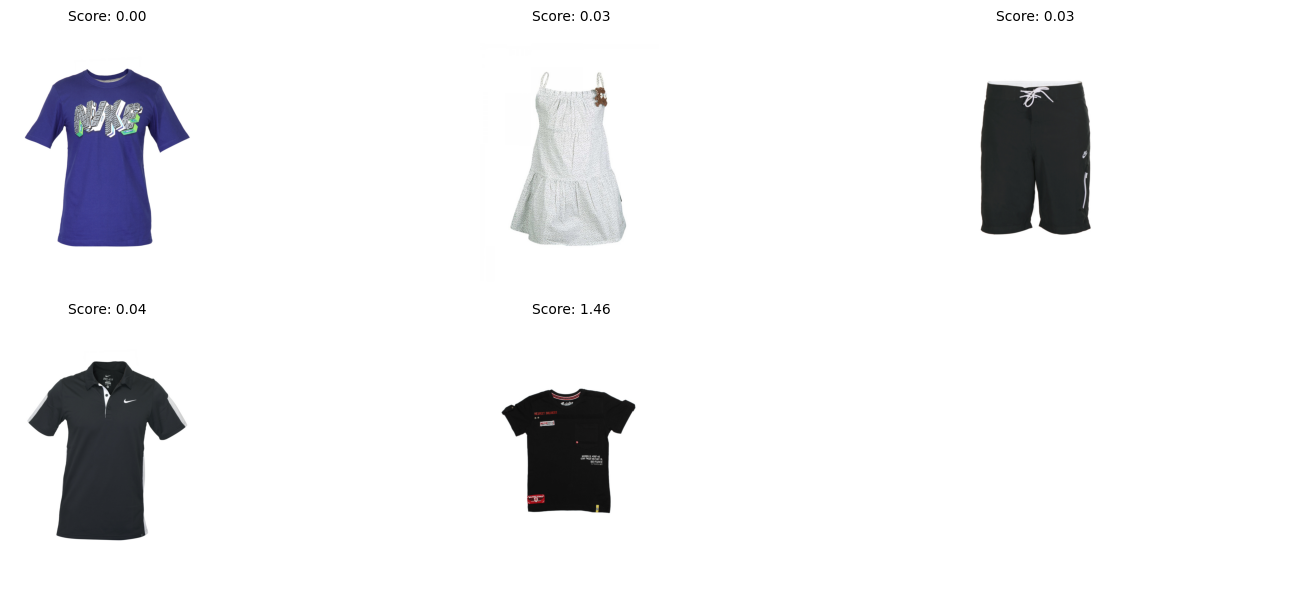

In [40]:
tree_orb_resnet_16_5_scores, tree_orb_resnet_16_5_images = tree_orb_resnet_16_5.query(query_test_img)
plot_top_k_images(tree_orb_resnet_16_5_scores, tree_orb_resnet_16_5_images, 5)

In [41]:
with open('trees\\tree_orb_resnet_16_5.pkl', 'wb') as f:
    pickle.dump(tree_orb_resnet_16_5, f)
f.close()

#### B:32, H:6

In [42]:
tree_orb_resnet_32_6 = VocabularyTree(num_branches=32, depth=6, image_descriptor_function=generate_orb_resnet_features)
tree_orb_resnet_32_6.fit(training_df['image_path'])

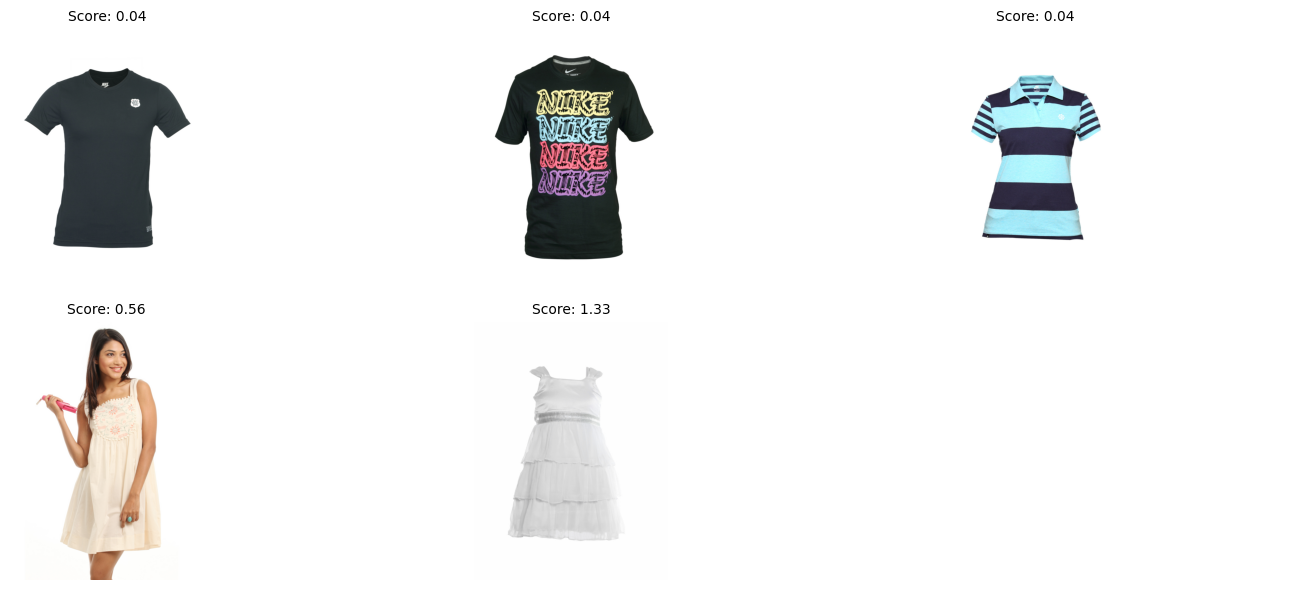

In [43]:
tree_orb_resnet_32_6_scores, tree_orb_resnet_32_6_images = tree_orb_resnet_32_6.query(query_test_img)
plot_top_k_images(tree_orb_resnet_32_6_scores, tree_orb_resnet_32_6_images, 5)

In [44]:
with open('trees\\tree_orb_resnet_32_6.pkl', 'wb') as f:
    pickle.dump(tree_orb_resnet_32_6, f)
f.close()

### Superpoint

#### B:16, H:5

In [196]:
tree_superpoint_16_5 = VocabularyTree(num_branches=16, depth=5, image_descriptor_function=superpoint_features)
tree_superpoint_16_5.fit(training_df['image_path'])

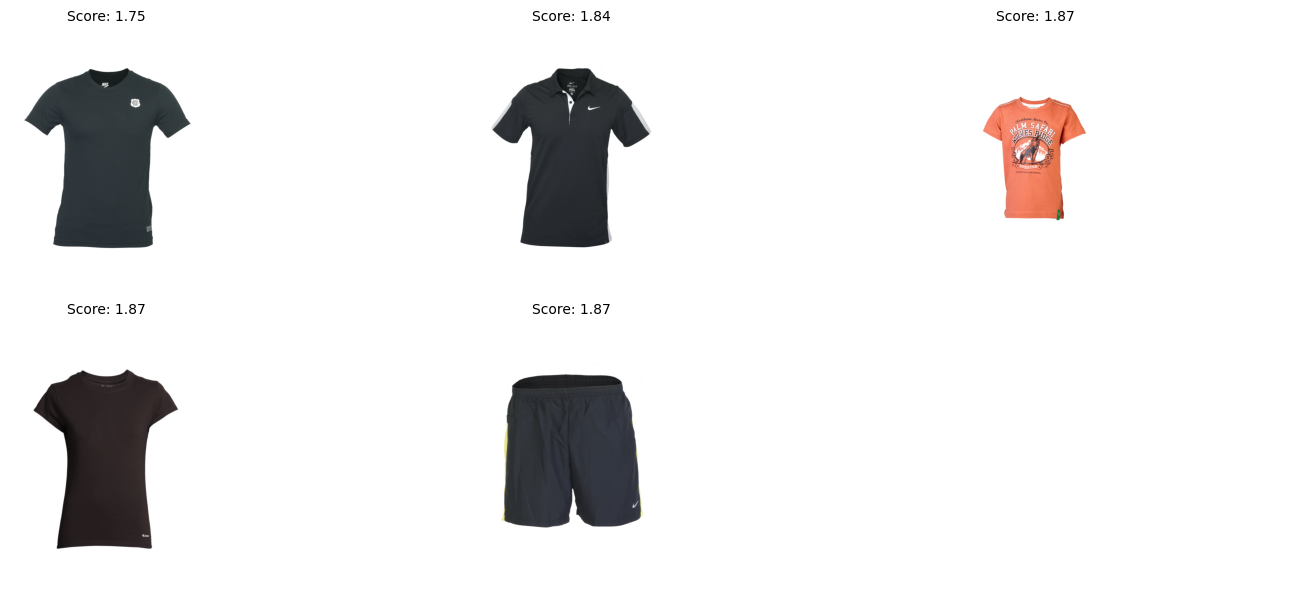

In [197]:
tree_superpoint_16_5_scores, tree_superpoint_16_5_images = tree_superpoint_16_5.query(query_test_img)
plot_top_k_images(tree_superpoint_16_5_scores, tree_superpoint_16_5_images, 5)

In [198]:
with open('trees\\tree_superpoint_16_5.pkl', 'wb') as f:
    pickle.dump(tree_superpoint_16_5, f)

f.close()

#### B:16, H:6

In [199]:
tree_superpoint_16_6 = VocabularyTree(num_branches=16, depth=6, image_descriptor_function=superpoint_features)
tree_superpoint_16_6.fit(training_df['image_path'])

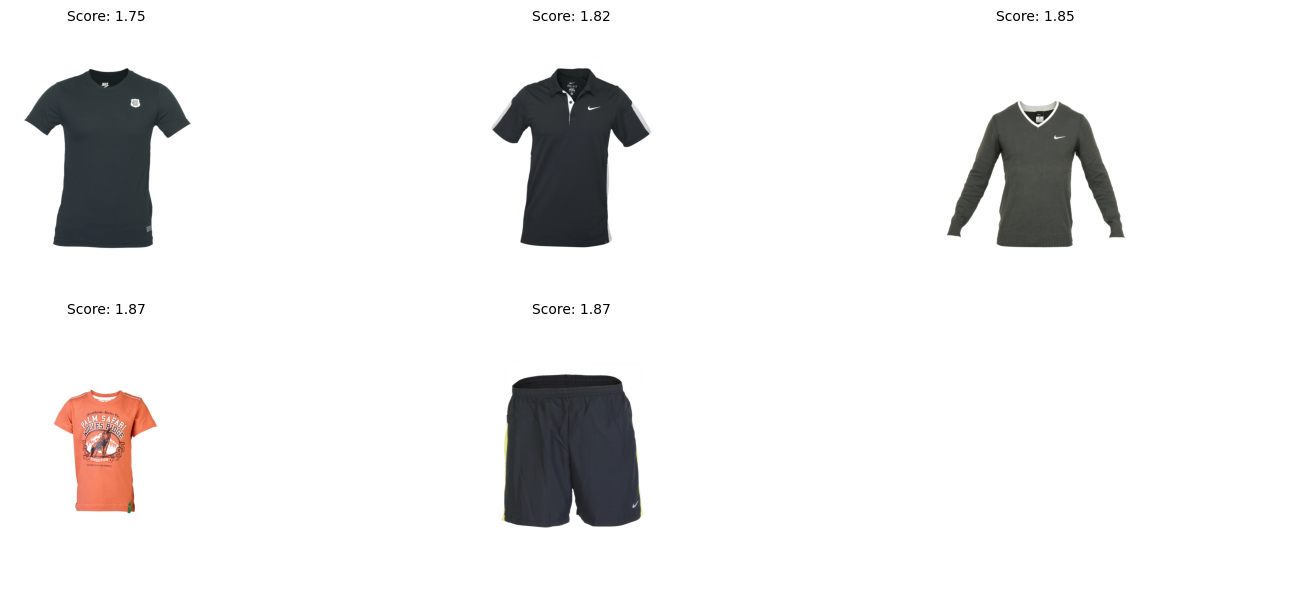

In [200]:
tree_superpoint_16_6_scores, tree_superpoint_16_6_images = tree_superpoint_16_6.query(query_test_img)
plot_top_k_images(tree_superpoint_16_6_scores, tree_superpoint_16_6_images, 5)

In [222]:
with open('trees\\tree_superpoint_16_6.pkl', 'wb') as f:
    pickle.dump(tree_superpoint_16_6, f)
f.close()

#### B:32, H:5

In [212]:
tree_superpoint_32_5 = VocabularyTree(num_branches=32, depth=5, image_descriptor_function=superpoint_features)
tree_superpoint_32_5.fit(training_df['image_path'])

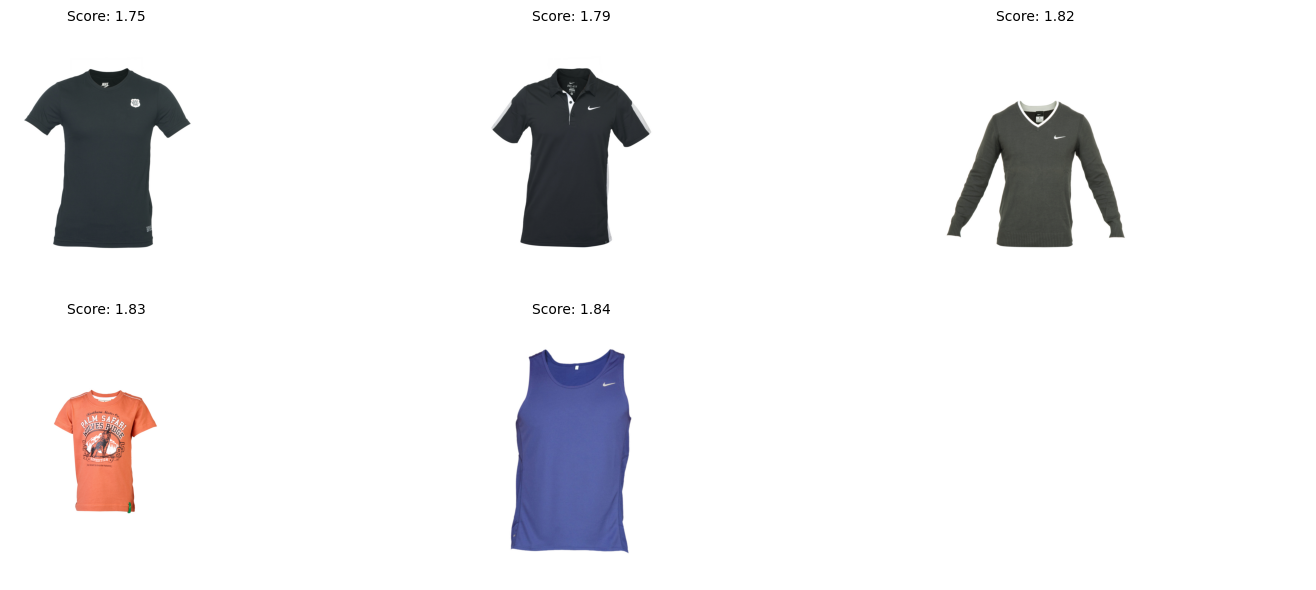

In [213]:
tree_superpoint_32_5_scores, tree_superpoint_32_5_images = tree_superpoint_32_5.query(query_test_img)
plot_top_k_images(tree_superpoint_32_5_scores, tree_superpoint_32_5_images, 5)

In [214]:
with open('trees\\tree_superpoint_32_5.pkl', 'wb') as f:
    pickle.dump(tree_superpoint_32_5, f)
f.close()

#### B:32, H:6

In [215]:
tree_superpoint_32_6 = VocabularyTree(num_branches=32, depth=6, image_descriptor_function=superpoint_features)
tree_superpoint_32_6.fit(training_df['image_path'])

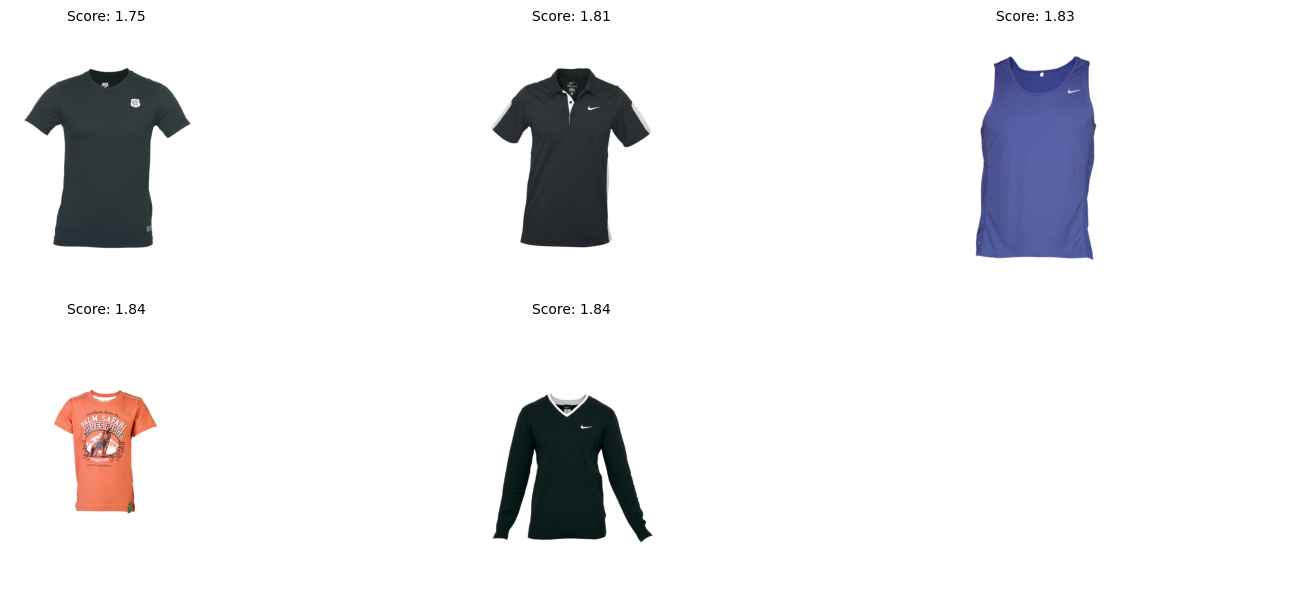

In [216]:
tree_superpoint_32_6_scores, tree_superpoint_32_6_images = tree_superpoint_32_6.query(query_test_img)
plot_top_k_images(tree_superpoint_32_6_scores, tree_superpoint_32_6_images, 5)

In [223]:
training_df['articleType'].value_counts()

articleType
Tshirts         125
Jeans           125
Sweaters        125
Shirts          125
Dresses         125
Shorts          125
Casual Shoes    125
Skirts          125
Name: count, dtype: int64

In [217]:
with open('trees\\tree_superpoint_32_6.pkl', 'wb') as f:
    pickle.dump(tree_superpoint_32_6, f)
f.close()

# Evaluation

In [49]:
def evaluation_metrics(query_img_label, match_scores, match_labels, top_k=5):
    """
    - query_img_label (int/str): Label of the query image.
    - match_scores (list of float): Relevance scores (Minowski distance)
    - match_labels (list of int/str): Labels of the recommended images corresponding to match_scores. 
    - top_k (int): Number of top items to consider .
    """
    
    ranked_results = sorted(zip(match_scores, match_labels), key=lambda x: x[0])
    
    top_k_results = ranked_results[:top_k]
    relevance_scores = [1 if label == query_img_label else 0 for _, label in top_k_results]
    total_relevant = sum(relevance_scores)
    
    if total_relevant == 0:
        return 0.0, 0.0 

    #  MAP
    precision_at_k = []
    for i, rel in enumerate(relevance_scores, start=1):
        if rel == 1:
            precision_at_k.append(sum(relevance_scores[:i]) / i)  
    map_score = sum(precision_at_k) / total_relevant

    # DCG
    dcg = sum(rel / np.log2(idx + 2) for idx, rel in enumerate(relevance_scores))
    
    # IDCG 
    ideal_relevance_scores = sorted(relevance_scores, reverse=True)
    idcg = sum(rel / np.log2(idx + 2) for idx, rel in enumerate(ideal_relevance_scores))

    ndcg_score = dcg / idcg if idcg > 0 else 0.0

    return map_score, ndcg_score

In [57]:
def perform_evaluation(test_df, tree_model):
    article_type_metrics = {'map': [], 'ndcg': []}
    color_type_metrics = {'map': [], 'ndcg': []}
    color_article_type_metrics = {'map': [], 'ndcg': []}

    for _, row in test_df.iterrows():
        eval_img = cv2.imread(row['image_path'])
        scores, images = tree_model.query(eval_img)
        
        match_scores = scores.values()
        match_article_labels = [training_df[training_df['image_path'] == v].iloc[0]['articleType'] for _, v in images.items()]
        match_color_labels = [training_df[training_df['image_path'] == v].iloc[0]['baseColour'] for _, v in images.items()]
        match_color_article_labels = [training_df[training_df['image_path'] == v].iloc[0]['color_articleType'] for _, v in images.items()]

        article_metric = evaluation_metrics(row['articleType'], match_scores, match_article_labels)
        color_metric = evaluation_metrics(row['baseColour'], match_scores, match_color_labels)
        color_article_metric = evaluation_metrics(row['color_articleType'], match_scores, match_color_article_labels)


        article_type_metrics['ndcg'].append(article_metric[0])
        article_type_metrics['map'].append(article_metric[1])

        color_type_metrics['ndcg'].append(color_metric[0])
        color_type_metrics['map'].append(color_metric[1])

        color_article_type_metrics['ndcg'].append(color_article_metric[0])
        color_article_type_metrics['map'].append(color_article_metric[1])
    
    metrics = {
        'Article Type MAP': np.mean(article_type_metrics['map']),
        'Article Type NDCG': np.mean(article_type_metrics['ndcg']),
        'Color Type MAP': np.mean(color_type_metrics['map']),
        'Color Type NDCG': np.mean(color_type_metrics['ndcg']),
        'Color and Article Type MAP': np.mean(color_article_type_metrics['map']),
        'Color and Article Type NDCG': np.mean(color_article_type_metrics['ndcg']),
    }
    
    return metrics

In [58]:
orb_baseline_16_5_metrics = perform_evaluation(test_df, tree_orb_baseline_16_5)

In [59]:
orb_baseline_16_5_metrics

{'Article Type MAP': np.float64(0.6602830209606672),
 'Article Type NDCG': np.float64(0.5887626262626263),
 'Color Type MAP': np.float64(0.47073590951015604),
 'Color Type NDCG': np.float64(0.4017385392385393),
 'Color and Article Type MAP': np.float64(0.26237221313393655),
 'Color and Article Type NDCG': np.float64(0.2187160062160062)}

In [60]:
opp_shift_32_6_metrics = perform_evaluation(test_df, tree_opp_sift_32_6)

In [61]:
opp_shift_32_6_metrics

{'Article Type MAP': np.float64(0.6006972882784665),
 'Article Type NDCG': np.float64(0.5378885003885003),
 'Color Type MAP': np.float64(0.4790825138335372),
 'Color Type NDCG': np.float64(0.40736208236208243),
 'Color and Article Type MAP': np.float64(0.27207987205771633),
 'Color and Article Type NDCG': np.float64(0.23368298368298365)}

In [62]:
orb_16_5_metrics = perform_evaluation(test_df, tree_orb_16_5)

In [63]:
orb_16_5_metrics

{'Article Type MAP': np.float64(0.7229985340857678),
 'Article Type NDCG': np.float64(0.6540306915306916),
 'Color Type MAP': np.float64(0.5252831397753637),
 'Color Type NDCG': np.float64(0.44529914529914527),
 'Color and Article Type MAP': np.float64(0.31659004443860744),
 'Color and Article Type NDCG': np.float64(0.2722902097902098)}

In [64]:
orb_32_6_metrics = perform_evaluation(test_df, tree_orb_32_6)

In [65]:
orb_32_6_metrics

{'Article Type MAP': np.float64(0.7458254649309073),
 'Article Type NDCG': np.float64(0.6682886557886558),
 'Color Type MAP': np.float64(0.5209550037111489),
 'Color Type NDCG': np.float64(0.44788267288267286),
 'Color and Article Type MAP': np.float64(0.34543337450691824),
 'Color and Article Type NDCG': np.float64(0.2947746697746697)}

In [66]:
orb_resnet_16_5_metrics = perform_evaluation(test_df, tree_orb_resnet_16_5)

In [67]:
orb_resnet_16_5_metrics

{'Article Type MAP': np.float64(0.7814138543832286),
 'Article Type NDCG': np.float64(0.7329642579642579),
 'Color Type MAP': np.float64(0.4454721684972211),
 'Color Type NDCG': np.float64(0.38596542346542345),
 'Color and Article Type MAP': np.float64(0.33607276126167324),
 'Color and Article Type NDCG': np.float64(0.2982323232323232)}

In [68]:
orb_resnet_32_6_metrics = perform_evaluation(test_df, tree_orb_resnet_32_6)

In [69]:
orb_resnet_32_6_metrics

{'Article Type MAP': np.float64(0.7662836562778557),
 'Article Type NDCG': np.float64(0.7206779331779332),
 'Color Type MAP': np.float64(0.45104309657382974),
 'Color Type NDCG': np.float64(0.38687839937839935),
 'Color and Article Type MAP': np.float64(0.3272233900464884),
 'Color and Article Type NDCG': np.float64(0.2807012432012432)}

In [71]:
with open('trees\\tree_superpoint_16_5.pkl', 'rb') as f:
    tree_superpoint_16_5 = pickle.load(f)
f.close()

with open('trees\\tree_superpoint_16_6.pkl', 'rb') as f:
    tree_superpoint_16_6 = pickle.load(f)
f.close()

with open('trees\\tree_superpoint_32_5.pkl', 'rb') as f:
    tree_superpoint_32_5 = pickle.load(f)
f.close()

with open('trees\\tree_superpoint_32_6.pkl', 'rb') as f:
    tree_superpoint_32_6 = pickle.load(f)
f.close()

In [72]:
superpoint_16_5_metrics = perform_evaluation(test_df, tree_superpoint_16_5)

In [73]:
superpoint_16_5_metrics

{'Article Type MAP': np.float64(0.8815028500441975),
 'Article Type NDCG': np.float64(0.8401029526029528),
 'Color Type MAP': np.float64(0.5169407723676681),
 'Color Type NDCG': np.float64(0.4457944832944833),
 'Color and Article Type MAP': np.float64(0.44583342511429125),
 'Color and Article Type NDCG': np.float64(0.37973970473970475)}

In [74]:
superpoint_16_6_metrics = perform_evaluation(test_df, tree_superpoint_16_6)

In [75]:
superpoint_16_6_metrics

{'Article Type MAP': np.float64(0.8852902645465459),
 'Article Type NDCG': np.float64(0.8491064491064493),
 'Color Type MAP': np.float64(0.4927895914185461),
 'Color Type NDCG': np.float64(0.41823038073038077),
 'Color and Article Type MAP': np.float64(0.4334880296565093),
 'Color and Article Type NDCG': np.float64(0.3732031857031857)}

In [76]:
superpoint_32_5_metrics = perform_evaluation(test_df, tree_superpoint_32_5)

In [77]:
superpoint_32_5_metrics

{'Article Type MAP': np.float64(0.8638473876566651),
 'Article Type NDCG': np.float64(0.8264957264957264),
 'Color Type MAP': np.float64(0.4992949368001806),
 'Color Type NDCG': np.float64(0.42413558663558665),
 'Color and Article Type MAP': np.float64(0.4407802886685073),
 'Color and Article Type NDCG': np.float64(0.3777000777000777)}

In [78]:
superpoint_32_6_metrics = perform_evaluation(test_df, tree_superpoint_32_6)

In [79]:
superpoint_32_6_metrics

{'Article Type MAP': np.float64(0.887303705376139),
 'Article Type NDCG': np.float64(0.856361693861694),
 'Color Type MAP': np.float64(0.502692108812388),
 'Color Type NDCG': np.float64(0.4238733488733489),
 'Color and Article Type MAP': np.float64(0.4259101370666012),
 'Color and Article Type NDCG': np.float64(0.3667346542346543)}

In [3]:
model_names = {}

metrics_df = pd.DataFrame([orb_baseline_16_5_metrics, opp_shift_32_6_metrics, orb_16_5_metrics, orb_32_6_metrics, orb_resnet_16_5_metrics, orb_resnet_32_6_metrics, 
                           superpoint_16_5_metrics, superpoint_16_6_metrics, superpoint_32_5_metrics, superpoint_32_6_metrics], 
                           )

metrics_df['model'] = ['Baseline ORB B:16, H:5', 'SIFT Opponent Color Spaces B:32, H:6', 'Multi Channel ORB B:16, H:5', 'Multi Channel ORB B:32, H:6', 
                       'ORB + Resnet B:16, H:5', 'ORB + Resnet B:32, H:6', 
                       'SuperPoint B:16, H:5', 'SuperPoint B:16, H:6', 'SuperPoint B:32, H:5', 'SuperPoint B:32, H:6']


NameError: name 'orb_baseline_16_5_metrics' is not defined

In [96]:
metrics_df.to_csv('metrics.csv', index=False)

In [97]:
metrics_df.set_index('model', inplace=True)

In [98]:
metrics_df

,Article Type MAP,Article Type NDCG,Color Type MAP,Color Type NDCG,Color and Article Type MAP,Color and Article Type NDCG
model,,,,,,
"Baseline ORB B:16, H:5",0.660283,0.588763,0.470736,0.401739,0.262372,0.218716
"SIFT Opponent Color Spaces B:32, H:6",0.600697,0.537889,0.479083,0.407362,0.272080,0.233683
"Multi Channel ORB B:16, H:5",0.722999,0.654031,0.525283,0.445299,0.316590,0.272290
"Multi Channel ORB B:32, H:6",0.745825,0.668289,0.520955,0.447883,0.345433,0.294775
"ORB + Resnet B:16, H:5",0.781414,0.732964,0.445472,0.385965,0.336073,0.298232
"ORB + Resnet B:32, H:6",0.766284,0.720678,0.451043,0.386878,0.327223,0.280701
"SuperPoint B:16, H:5",0.881503,0.840103,0.516941,0.445794,0.445833,0.379740
"SuperPoint B:16, H:6",0.885290,0.849106,0.492790,0.418230,0.433488,0.373203
"SuperPoint B:32, H:5",0.863847,0.826496,0.499295,0.424136,0.440780,0.377700


In [ ]:
metrics_df = pd.read_csv('metrics.csv')
metrics_df.rename(columns={'Article Type MAP': 'Garment Type MAP', 'Article Type NDCG': 'Garment Type NDCG'}, inplace=True)
metrics_df.set_index('model', inplace=True)

In [8]:
metrics_df

,Garment Type MAP,Garment Type NDCG,Color Type MAP,Color Type NDCG,Color and Article Type MAP,Color and Article Type NDCG
model,,,,,,
"Baseline ORB B:16, H:5",0.660283,0.588763,0.470736,0.401739,0.262372,0.218716
"SIFT Opponent Color Spaces B:32, H:6",0.600697,0.537889,0.479083,0.407362,0.272080,0.233683
"Multi Channel ORB B:16, H:5",0.722999,0.654031,0.525283,0.445299,0.316590,0.272290
"Multi Channel ORB B:32, H:6",0.745825,0.668289,0.520955,0.447883,0.345433,0.294775
"ORB + Resnet B:16, H:5",0.781414,0.732964,0.445472,0.385965,0.336073,0.298232
"ORB + Resnet B:32, H:6",0.766284,0.720678,0.451043,0.386878,0.327223,0.280701
"SuperPoint B:16, H:5",0.881503,0.840103,0.516941,0.445794,0.445833,0.379740
"SuperPoint B:16, H:6",0.885290,0.849106,0.492790,0.418230,0.433488,0.373203
"SuperPoint B:32, H:5",0.863847,0.826496,0.499295,0.424136,0.440780,0.377700


In [9]:
metrics_df['Time(s)'] = ['5', '20', '5', '5', '7', '7', '5', '5', '5', '5']

In [10]:
metrics_df

,Garment Type MAP,Garment Type NDCG,Color Type MAP,Color Type NDCG,Color and Article Type MAP,Color and Article Type NDCG,Time(s)
model,,,,,,,
"Baseline ORB B:16, H:5",0.660283,0.588763,0.470736,0.401739,0.262372,0.218716,5
"SIFT Opponent Color Spaces B:32, H:6",0.600697,0.537889,0.479083,0.407362,0.272080,0.233683,20
"Multi Channel ORB B:16, H:5",0.722999,0.654031,0.525283,0.445299,0.316590,0.272290,5
"Multi Channel ORB B:32, H:6",0.745825,0.668289,0.520955,0.447883,0.345433,0.294775,5
"ORB + Resnet B:16, H:5",0.781414,0.732964,0.445472,0.385965,0.336073,0.298232,7
"ORB + Resnet B:32, H:6",0.766284,0.720678,0.451043,0.386878,0.327223,0.280701,7
"SuperPoint B:16, H:5",0.881503,0.840103,0.516941,0.445794,0.445833,0.379740,5
"SuperPoint B:16, H:6",0.885290,0.849106,0.492790,0.418230,0.433488,0.373203,5
"SuperPoint B:32, H:5",0.863847,0.826496,0.499295,0.424136,0.440780,0.377700,5
